### Importing Libraries:

In [33]:
import numpy as np
from datetime import datetime
import os
import csv
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import pytz
from scipy.fftpack import fft
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.cross_validation import cross_val_score as cvs
from sklearn.preprocessing import LabelEncoder as le
from sklearn.learning_curve import learning_curve
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.cross_validation import StratifiedShuffleSplit as sss
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix

### Creating path variables:

In [28]:
data_path = '/Users/narenjhabakh/desktop/hackathon/CMU-Enernoc/data'
files = os.listdir(data_path)

### Importing Metadata file into data frame:

In [81]:
attr=pd.read_csv(data_path+'/'+files[len(files)-1])

In [82]:
attr.head()

,siteid,lat,lng,industry,subindustry,timezone
0,a6037ce7e019fa6a1e73395d8c8299f9,28.185264,-81.801340,Commercial Property,Big Box Retail,America/New_York
1,27495cc4fd15b05c6a84ca983abd5205,40.761742,-74.035391,Light Industrial,Manufacturing,America/New_York
2,c0f71d45d17acc537857ac2806425bdc,40.779799,-75.941054,Heavy Industrial,Other Heavy Industrial,America/New_York
3,8715cdaf42dc19096145a6c9f74e1e38,40.016951,-74.800285,Light Industrial,Manufacturing,America/New_York
4,c5497da6320ea4da1082667930d3b027,39.273233,-75.900825,Light Industrial,Graphics & Printing,America/New_York


### Data Processing (Exploration):

##### Converting UTC to local time:

In [240]:
def utc_to_time(native, timezone):
    return native.replace(tzinfo=pytz.utc).astimezone(pytz.timezone(timezone))

##### Function to get typical average week consumption for each site:

In [273]:
def get_attr_data(file_path):
    attr_df = pd.read_csv(file_path,header=0,usecols=["siteid","industry","timezone"])
    
    return attr_df

def avg_week_consumption(attr_df,folder_path):
    avg_week_vector = pd.DataFrame(index=np.arange(0,168),columns = attr_df.siteid,dtype=float)
    
    for i in range(0,len(attr_df.siteid)):
        df = pd.read_csv(folder_path+'/'+attr_df.siteid[i]+'.csv')
        df['dttm'] = pd.to_datetime(df['dttm'])
        df['dttm'] = df.dttm.apply(lambda x: utc_to_time(x,attr_df.timezone[i]))
        df['Hour'] = df.dttm.apply(lambda x: x.hour)
        df['DoW'] = df.dttm.apply(lambda x: x.dayofweek)
        w = df.groupby(['DoW','Hour']).sum().demand_kWh
        #Resetting index because of multi indexing
        avg_week_vector[attr_df.siteid[i]] = w.reset_index(drop=True)
    
    avg_week_vector = avg_week_vector.T.reset_index()
    avg_week_vector.values[0]= 'siteid'
    return avg_week_vector
        
        
    
    
    


In [223]:
attr = get_attr_data(data_path+'/'+files[len(files)-1])


In [274]:
df = avg_week_consumption(attr,data_path)

##### Saving Data Frame to pickle:

In [275]:
df.to_pickle('Avg_week.pkl')

In [276]:
df_final = pd.merge(attr,df,on='siteid',how='inner')

### Plotting typical week consumption (hourly resolution):

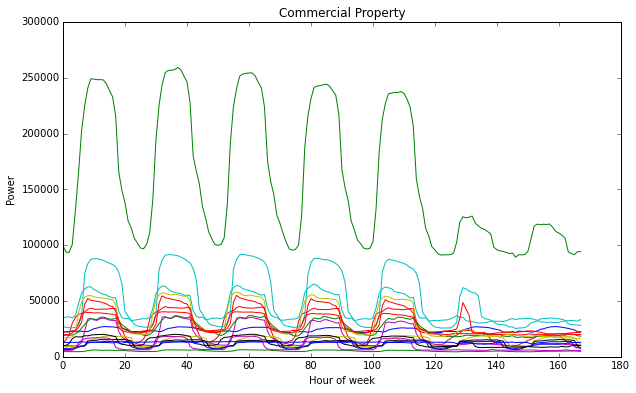

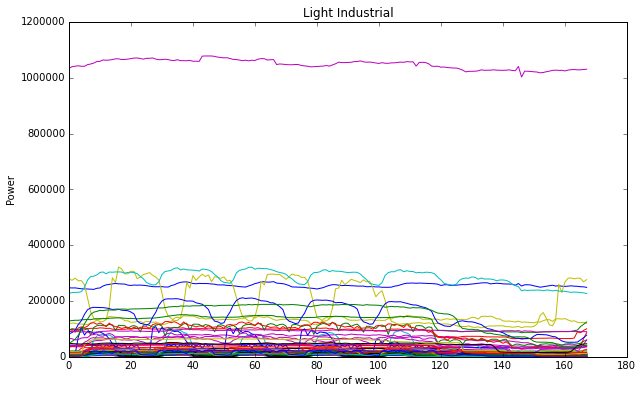

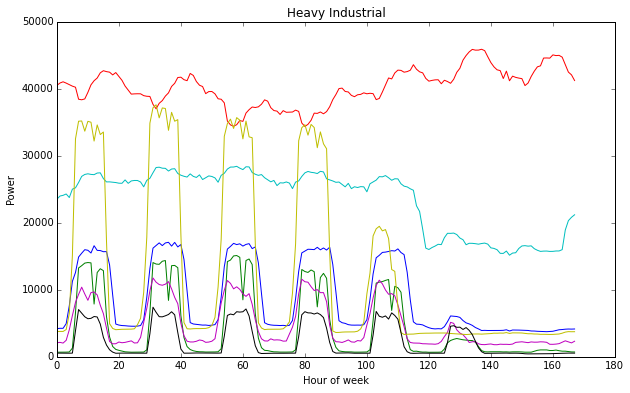

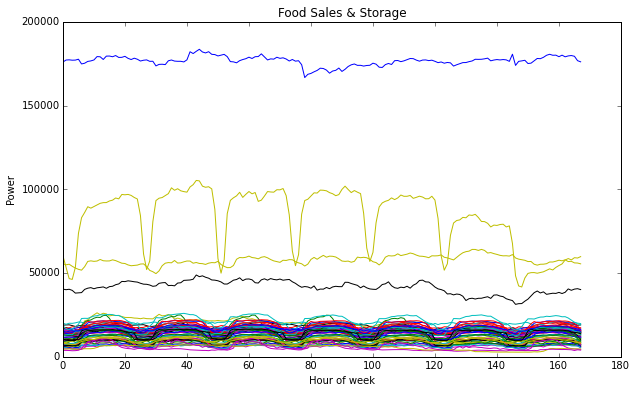

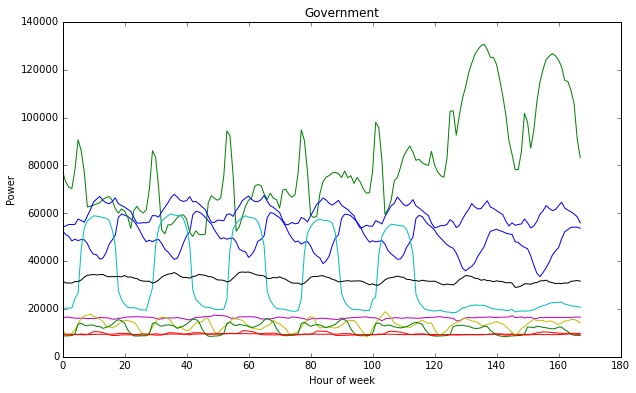

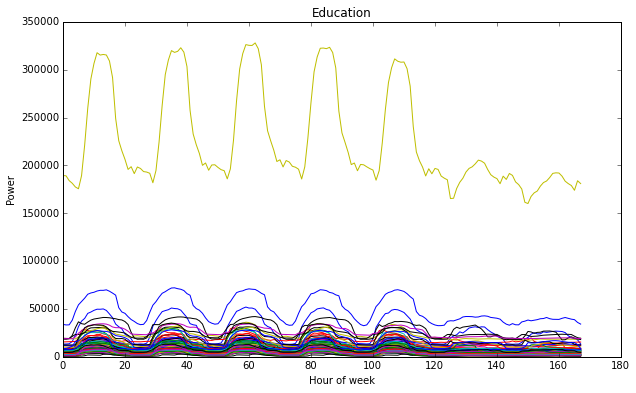

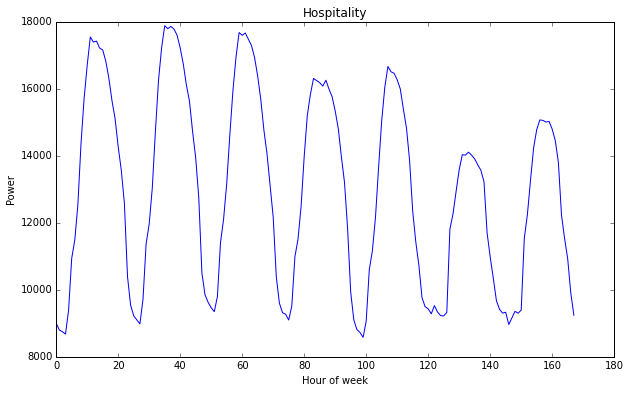

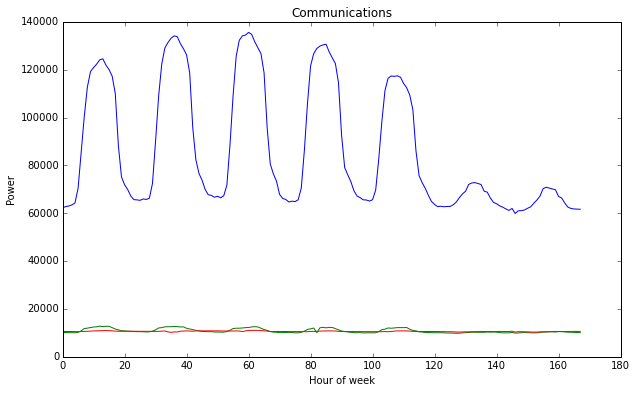

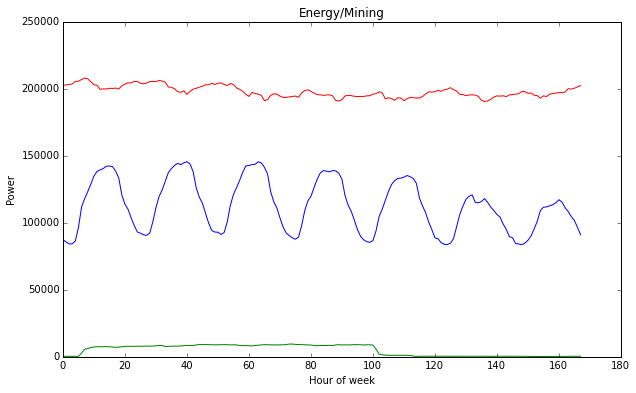

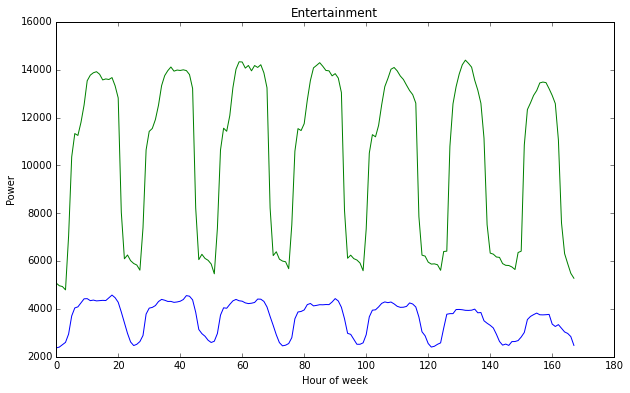

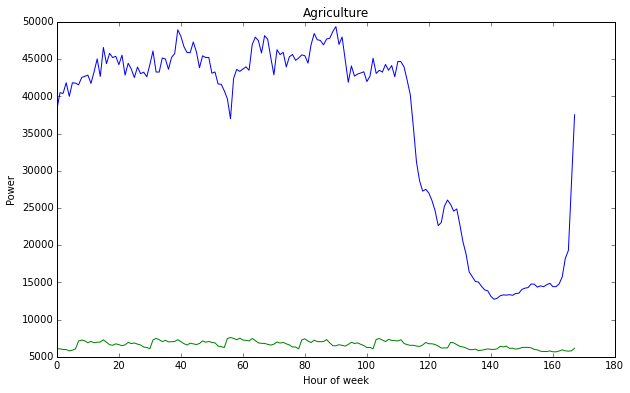

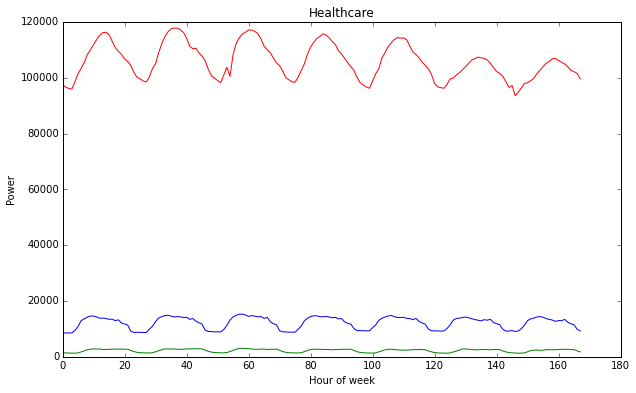

In [492]:
plot_list = pd.unique(attr.industry)
for i in plot_list:
    sub_df = df_final[df_final.industry==i].reset_index()
    fig, ax = plt.subplots(figsize=(10,6))
    for j in range(0,len(sub_df.siteid)):
        ax.plot(sub_df.ix[j,4:])
    plt.title(i,size=12)
    plt.xlabel('Hour of week')
    plt.ylabel('Power')
plt.show()

### Interactive Plot 

In [566]:
import plotly.plotly as py
import plotly.graph_objs as go


#plot_list = pd.unique(attr.industry)
# for i in plot_list:
sub_df = df_final[df_final.industry==plot_list[0]].reset_index()
    #fig, ax = plt.subplots(figsize=(10,6))
trace=[]
for j in range(0,len(sub_df.siteid)):
    trace.append(go.Scatter(x=list(range(1,169)),y=sub_df.ix[j,0:],mode='lines',name=sub_df.ix[j,'timezone']),)
    #plt.title(i,size=12)
    #plt.xlabel('Hour of week')
    #plt.ylabel('Power')
#plt.show()
layout=dict(title = plot_list[0],xaxis=dict(title='Hour of week'),yaxis=dict(title='kWh'),)
data = [trace[i] for i in range(0,len(sub_df.siteid))]
#plot_url = py.plot(data, filename=plot_list[0])
fig=dict(data=data,layout=layout)
py.iplot(fig,filename='Test')

### Data Processing (Feature Extraction):

In [567]:
def fourier_analysis(series):
    freq_power = np.zeros(4)
    fft_signal = abs(fft(series))
    j=0
    for i in [52,104,260,365]:
        freq_power[j] = max(fft_signal[i-10:i+10])
        j+=1
    
    return freq_power

def feature_extraction(attr_df,folder_path):
    features = pd.DataFrame(index = attr_df.siteid,columns=['95Perc/Mean','WkDay/WkEnd','365_y','104_y','260_y','52_y','Occ%','Unocc%'],dtype=float)
    occ = list(range(7,19))
    for i in range(0,len(attr_df.siteid)):
        df = pd.read_csv(folder_path+'/'+attr_df.siteid[i]+'.csv')
        df['dttm'] = pd.to_datetime(df['dttm'])
        df['dttm'] = df.dttm.apply(lambda x: utc_to_time(x,attr_df.timezone[i]))
        df['Hour'] = df.dttm.apply(lambda x: x.hour)
        df.demand_kWh = df.demand_kWh.fillna(method='bfill')
        Total_kWh = df.demand_kWh.sum()
        features.ix[attr_df.siteid[i],['95Perc/Mean']] = np.percentile(df.demand_kWh,95)/df.demand_kWh.mean()
        features.ix[attr_df.siteid[i],['Occ/Unocc']] = df.demand_kWh[df.Hour.isin(occ)].sum()/df.demand_kWh[~(df.Hour.isin(occ))].sum()
        features.ix[attr_df.siteid[i],['WkDay/WkEnd']] = df.demand_kWh[df.DoY <5].sum()/df.demand_kWh[df.DoY>=5].sum()
        features.ix[attr_df.siteid[i],['52_y','104_y','260_y','365_y']] = fourier_analysis(df.demand_kWh) 
        features.reset_index(inplace=True)
        
    return features
        

In [340]:
df_f = feature_extraction(attr,data_path)

##### Saving Data Feature Frame to pickle:

In [341]:
df_f.to_pickle('Features.pkl')

##### Printing Feature Data Frame:

In [495]:
df_f.head(2)

,siteid,95Perc/Mean,WkDay/WkEnd,365_y,260_y,104_y,52_y,Occ/Unocc
0,a6037ce7e019fa6a1e73395d8c8299f9,1.305618,2.501029,189839.782294,8976.238226,19709.121843,26005.824715,1.097859
1,27495cc4fd15b05c6a84ca983abd5205,1.165327,2.487399,496090.153307,214624.630330,545854.412445,1157811.049823,1.011110


##### Merging Industry labels and Timezone with Feature DF using siteID as key

In [496]:
features = pd.merge(attr,features_df,on='siteid',how='inner')

In [501]:
pd.value_counts(features.industry.ravel())

Education               70
Light Industrial        66
Food Sales & Storage    64
Commercial Property     17
Government              10
Heavy Industrial         7
dtype: int64

##### Timezone encoded in numbers and used as a feature

In [498]:
enc = le()
features.timezone = enc.fit_transform(features.timezone)

In [499]:
features.dropna(axis=0,inplace=True)

##### Removing less than 7 instances

In [500]:
scant_instances = ['Hospitality','Agriculture','Entertainment','Communications','Energy/Mining','Healthcare']
for i in scant_instances:
    features = features[~(features.industry==i)]

### Classification with Random Forest and cross-validation:

In [502]:
X = features.ix[:,2:]
y = features.ix[:,1]
print(cvs(RFC(),X,y,cv=5))

[ 0.57  0.6   0.76  0.7   0.67]


##### Function to plot Confusion Matrix:

In [439]:
def plot_confusion_matrix(cm,title='Confusion Matrix', cmap=plt.cm.Reds):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(pd.unique(y.ravel())))
    plt.xticks(tick_marks,pd.unique(y.ravel()),rotation=90,fontsize=8)
    plt.yticks(tick_marks,pd.unique(y.ravel()),fontsize=8)
    plt.tight_layout()
    plt.ylabel('True_label',fontsize=12)
    plt.xlabel('Predicted_label',fontsize=12)

In [481]:
split_set = sss(y,test_size=.3,random_state=20)
for train_index, test_index in split_set:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]



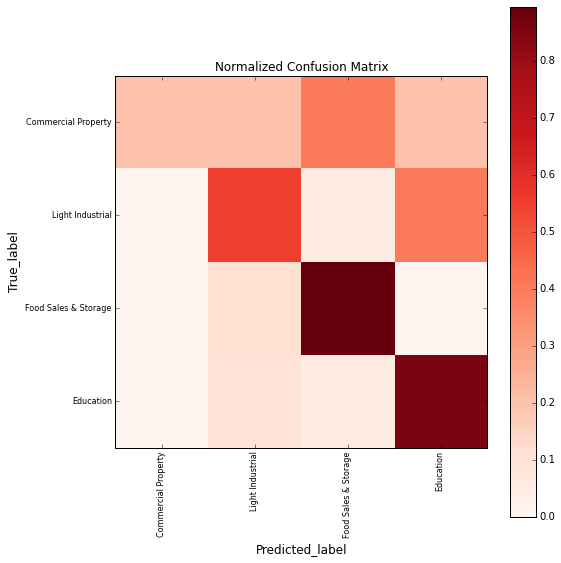

In [482]:
clf = RFC()
clf = clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)
cm = confusion_matrix(y_test,y_predict,labels=np.array(pd.unique(y.ravel())))
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized,title='Normalized Confusion Matrix')
plt.show()

##### Plot Learning Curve

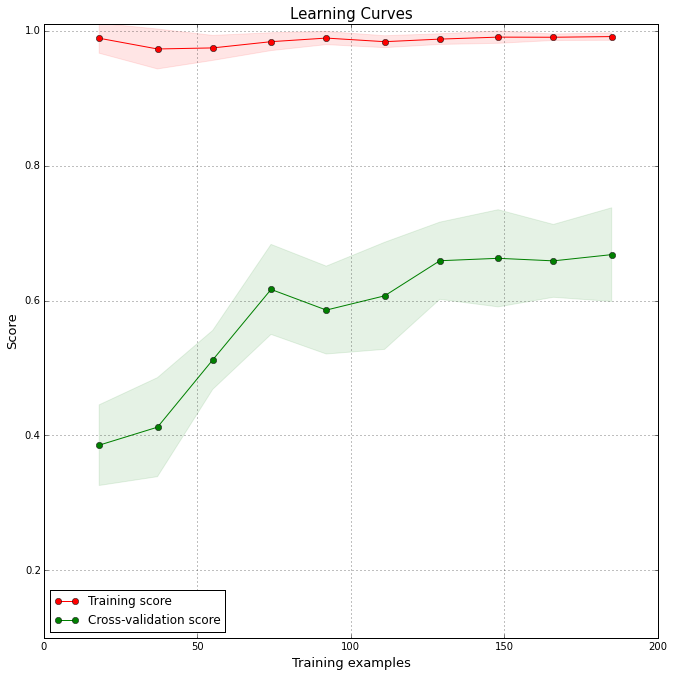

In [503]:
def plot_learning_curve(estimator, title, X,y,ylim=None,cv=None,n_jobs=1, train_sizes = np.linspace(.1,1.0,10)):
    plt.figure(figsize=(11,11))
    plt.title(title,size=15)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples",size=13)
    plt.ylabel("Score",size=13)
    train_sizes, train_scores, test_scores = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std, alpha=0.1,color='r')
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std, alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label="Training score")
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",label="Cross-validation score")
    plt.legend(loc="best")
    return plt

title = "Learning Curves"
plot_learning_curve(RFC(),title,X,y,(0.1,1.01),cv=5,n_jobs=4)
plt.show()